# MODEL IMPLEMENTATION

In [1]:
rWald = function(n, B, v, A)
  # random deviate function for single acumulator
{
  rwaldt = function(n, k, l, tiny = 1e-6) {
    # random sample of n from a Wald (or Inverse Gaussian)
    # k = criterion, l = rate, assumes sigma=1 Browninan motion
    # about same speed as statmod rinvgauss
    
    rlevy = function(n = 1, m = 0, c = 1) {
      if (any(c < 0))
        stop("c must be positive")
      c / qnorm(1 - runif(n) / 2) ^ 2 + m
    }
    
    flag     = l > tiny
    x        = rep(NA, times = n)
    x[!flag] = rlevy(sum(!flag), 0, k[!flag] ^ 2)
    mu       = k / l
    lambda   = k ^ 2
    y        = rnorm(sum(flag)) ^ 2
    mu.0     = mu[flag]
    lambda.0 = lambda[flag]
    x.0      = mu.0 + mu.0 ^ 2 * y / (2 * lambda.0) -
      sqrt(4 * mu.0 * lambda.0 * y + mu.0 ^ 2 * y ^ 2) * mu.0 /
      (2 * lambda.0)
    
    z             = runif(length(x.0))
    test          = mu.0 / (mu.0 + x.0)
    x.0[z > test] = mu.0[z > test] ^ 2 / x.0[z > test]
    x[flag]       = x.0
    x[x < 0]      = max(x)
    x
  }
  
  # Act as if negative v never terminates, cluge to do single accumulator
  # case by passing negative v
  if (length(v) != n)
    v = rep(v, length.out = n)
  if (length(B) != n)
    B = rep(B, length.out = n)
  if (length(A) != n)
    A = rep(A, length.out = n)
  
  # Kluge to return -Inf for negative rates, so can implment one accumulator case
  out      = numeric(n)
  ok       = v > 0
  nok      = sum(ok)
  bs       = B[ok] + runif(nok, 0, A[ok])
  out[ok]  = rwaldt(nok, k = bs, l = v[ok])
  out[!ok] = Inf
  out
}

In [2]:
dWald = function(t, v, B, A)
{
  digt = function(t, k = 1, l = 1, a = .1, tiny = 1e-10) {
    # pdf of inverse gaussian at t with k +/- a/2 uniform variability
    # returns digt.0 if a<1e-10
    
    digt.0 = function(t, k = 1, l = 1) {
      # pdf of inverse gaussian at t with no k variability
      # much faster than statmod's dinvgauss funciton
      
      lambda = k ^ 2
      l0     = l == 0
      e      = numeric(length(t))
      if (any(!l0)) {
        mu     = k[!l0] / l[!l0]
        e[!l0] =
          -(lambda[!l0] / (2 * t[!l0])) * (t[!l0] ^ 2 / mu ^ 2 - 2 * t[!l0] / mu  + 1)
      }
      if (any(l0))
        e[l0]   = -.5 * lambda[l0] / t[l0]
      x         = exp(e + .5 * log(lambda) - .5 * log(2 * t ^ 3 * pi))
      x[t <= 0] = 0
      x
    }
    
    options(warn = -1)
    if (length(k) != length(t))
      k = rep(k, length.out = length(t))
    if (length(l) != length(t))
      l = rep(l, length.out = length(t))
    if (length(a) != length(t))
      a = rep(a, length.out = length(t))
    
    tpos = t <= 0
    
    atiny    = a <= tiny & !tpos
    a[atiny] = 0
    
    ltiny        = (l <= tiny) & !atiny & !tpos
    notltiny     = (l > tiny) & !atiny & !tpos
    l[l <= tiny] = 0
    x            = numeric(length(t))
    
    # No threshold variability
    if (any(atiny))
      x[atiny] = digt.0(t = t[atiny], k = k[atiny], l = l[atiny])
    
    # Threshold variability
    if (any(!atiny)) {
      if (any(notltiny)) {
        # rate non-zero
        
        sqr.t   = sqrt(t[notltiny])
        
        term.1a =
          -(a[notltiny] - k[notltiny] + t[notltiny] * l[notltiny]) ^ 2 / (2 * t[notltiny])
        term.1b =
          -(a[notltiny] + k[notltiny] - t[notltiny] * l[notltiny]) ^ 2 / (2 * t[notltiny])
        term.1  =
          (exp(term.1a) - exp(term.1b)) / sqrt(2 * pi * t[notltiny])
        
        term.2a = log(.5) + log(l[notltiny])
        term.2b =
          2 * pnorm((-k[notltiny] + a[notltiny]) / sqr.t + sqr.t * l[notltiny]) -
          1
        term.2c =
          2 * pnorm((k[notltiny] + a[notltiny]) / sqr.t - sqr.t * l[notltiny]) -
          1
        term.2d = term.2b + term.2c
        term.2  = exp(term.2a) * term.2d
        
        term.3  = term.1 + term.2
        term.4  = log(term.3) - log(2) - log(a[notltiny])
        x[notltiny] = exp(term.4)
      }
      
      if (any(ltiny)) {
        # rate zero
        log.t    = log(t[ltiny])
        term.1   = -.5 * (log(2) + log(pi) + log.t)
        term.2   = (k[ltiny] - a[ltiny]) ^ 2 / (2 * t[ltiny])
        term.3   = (k[ltiny] + a[ltiny]) ^ 2 / (2 * t[ltiny])
        term.4   = (exp(-term.2) - exp(-term.3))
        term.5   = term.1 + log(term.4) - log(2) - log(a[ltiny])
        x[ltiny] = exp(term.5)
      }
      
    }
    
    x[x < 0 | is.nan(x)] = 0
    x
  }
  
  out      = numeric(length(t))
  ok       = v > 0
  out[ok]  = digt(t[ok],
                   k = B[ok] + A[ok] / 2,
                   l = v[ok],
                   a = A[ok] / 2)
  out[!ok] = 0
  out
}

In [3]:
pWald = function(t, v, B, A)
  # cumulative density for single accumulator
{
  pigt = function(t, k = 1, l = 1, a = .1, tiny = 1e-10) {
    # cdf of inverse gaussian at t with k +/- a/2 uniform variability
    # returns pigt.0 if a<=0
    
    pigt.0 = function(t, k = 1, l = 1) {
      # cdf of inverse gaussian at t with no k variability
      # much faster than statmod's pinvgauss funciton
      
      mu       = k / l
      lambda   = k ^ 2
      e        = exp(log(2 * lambda) - log(mu))
      add      = sqrt(lambda / t) * (1 + t / mu)
      sub      = sqrt(lambda / t) * (1 - t / mu)
      p.1      = 1 - pnorm(add)
      p.2      = 1 - pnorm(sub)
      x        = exp(e + log(p.1)) + p.2
      
      x[t < 0] = 0
      x
    }
    
    options(warn = -1)
    if (length(k) != length(t))
      k  = rep(k, length.out = length(t))
    if (length(l) != length(t))
      l  = rep(l, length.out = length(t))
    if (length(a) != length(t))
      a  = rep(a, length.out = length(t))
    
    tpos = t <= 0
    
    atiny    = a <= tiny & !tpos
    a[atiny] = 0
    
    ltiny        = (l <= tiny) & !atiny & !tpos
    notltiny     = (l > tiny) & !atiny & !tpos
    l[l <= tiny] = 0
    
    x = numeric(length(t))
    
    # No threshold variability
    if (any(atiny))
      x[atiny] = pigt.0(t[atiny], k[atiny], l[atiny])
    
    # Threshold variability
    if (any(!atiny)) {
      if (any(notltiny)) {
        # rate non-zero
        
        log.t   = log(t[notltiny])
        sqr.t   = sqrt(t[notltiny])
        
        term.1a = .5 * log.t - .5 * log(2 * pi)
        term.1b =
          exp(-((k[notltiny] - a[notltiny] - t[notltiny] * l[notltiny]) ^ 2 / t[notltiny]) /
                2)
        term.1c =
          exp(-((k[notltiny] + a[notltiny] - t[notltiny] * l[notltiny]) ^ 2 / t[notltiny]) /
                2)
        term.1  = exp(term.1a) * (term.1b - term.1c)
        
        term.2a = exp(2 * l[notltiny] * (k[notltiny] - a[notltiny]) +
                         log(pnorm(-(
                           k[notltiny] - a[notltiny] + t[notltiny] * l[notltiny]
                         ) / sqr.t)))
        term.2b = exp(2 * l[notltiny] * (k[notltiny] + a[notltiny]) +
                         log(pnorm(-(
                           k[notltiny] + a[notltiny] + t[notltiny] * l[notltiny]
                         ) / sqr.t)))
        term.2  = a[notltiny] + (term.2b - term.2a) / (2 * l[notltiny])
        
        term.4a =
          2 * pnorm((k[notltiny] + a[notltiny]) / sqr.t - sqr.t * l[notltiny]) -
          1
        term.4b =
          2 * pnorm((k[notltiny] - a[notltiny]) / sqr.t - sqr.t * l[notltiny]) -
          1
        term.4c =
          .5 * (t[notltiny] * l[notltiny] - a[notltiny] - k[notltiny] + .5 / l[notltiny])
        term.4d =
          .5 * (k[notltiny] - a[notltiny] - t[notltiny] * l[notltiny] - .5 / l[notltiny])
        term.4  = term.4c * term.4a + term.4d * term.4b
        
        x[notltiny] = (term.4 + term.2 + term.1) / (2 * a[notltiny])
      }
      
      if (any(ltiny)) {
        # rate zero
        sqr.t   = sqrt(t[ltiny])
        log.t   = log(t[ltiny])
        term.5a = 2 * pnorm((k[ltiny] + a[ltiny]) / sqr.t) - 1
        term.5b = 2 * pnorm(-(k[ltiny] - a[ltiny]) / sqr.t) - 1
        term.5  =
          (-(k[ltiny] + a[ltiny]) * term.5a - (k[ltiny] - a[ltiny]) * term.5b) /
          (2 * a[ltiny])
        
        term.6a =
          -.5 * (k[ltiny] + a[ltiny]) ^ 2 / t[ltiny] - .5 * log(2) - .5 * log(pi) + .5 *
          log.t - log(a[ltiny])
        term.6b =
          -.5 * (k[ltiny] - a[ltiny]) ^ 2 / t[ltiny] - .5 * log(2) - .5 * log(pi) + .5 *
          log.t - log(a[ltiny])
        term.6 = 1 + exp(term.6b) - exp(term.6a)
        
        x[ltiny] = term.5 + term.6
      }
      
    }
    
    x[x < 0 | is.nan(x)] = 0
    x
  }
  
  out = numeric(length(t))
  ok = v > 0
  out[ok] = pigt(t[ok],
                  k = B[ok] + A[ok] / 2,
                  l = v[ok],
                  a = A[ok] / 2)
  out[!ok] = 0
  out
  
}

In [4]:
rWaldRace = function(n, v, B, A, t0, gf = 0, return.ttf = FALSE)
  # random function for Wald race.
{
  B[B < 0] = 0 # Protection for negatives
  A[A < 0] = 0
  n_v      = ifelse(is.null(dim(v)), length(v), dim(v)[1])
  ttf      = matrix(t0 + rWald(n * n_v, B = B, v = v, A = A), nrow = n_v)
  if (return.ttf)
    return(ttf)
  resp = apply(ttf, 2, which.min)
  out  = data.frame(RT = ttf[cbind(resp, 1:n)], R = resp)
  
  for (i in 1:n_v) {
    out[[paste0("RT_acc", i)]] = ttf[i, ]
  }
  
  # Handle go failures
  if (gf[1] > 0) {
    is.gf = as.logical(rbinom(n, 1, gf))
    out$RT_winner[is.gf] = NA
    out$Winner[is.gf] = 1
    for (i in 1:n_v) {
      out[[paste0("RT_racer", i)]][is.gf] = NA
    }
  }
  
  out
}

In [5]:
n1Wald = function(dt, v, B, A, t0, gf = 0)
  # Generates defective PDF for responses on node=1, dt (decison time) is a vector of times
{
  B[B < 0] = 0 # Protection for negatives
  A[A < 0] = 0
  n_acc = ifelse(is.null(dim(v)), length(v), dim(v)[1])
  if (is.null(dim(dt)))
    dt = matrix(rep(dt, each = n_acc), nrow = n_acc)
  dt = dt - t0
  
  is.go = !is.na(dt[1, ])
  n.go = sum(is.go)
  
  if (!is.matrix(v))
    v = matrix(rep(v, n.go), nrow = n_acc)
  if (!is.matrix(B))
    B = matrix(rep(B, n.go), nrow = n_acc)
  if (!is.matrix(A))
    A = matrix(rep(A, n.go), nrow = n_acc)
  
  # Winner
  dt[1, is.go] =
    (1 - gf[1]) * dWald(dt[1, is.go], A = A[1, ], v = v[1, ], B = B[1, ])
  if (n_acc > 1)
    for (i in 2:n_acc)
      dt[1, is.go] =
    dt[1, is.go] * (1 - pWald(dt[i, is.go], A = A[i, ], v = v[i, ], B = B[i, ]))
  
  dt[1, !is.go] = gf[1]
  
  dt[1, ]
}

In [6]:
library(tidyverse)
library(dplyr)
library(ggplot2)
options(repr.plot.width = 12, repr.plot.height = 5)  # For RStudio/Jupyter
dev.new(width = 12, height = 5)  # For base R graphics


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [200]:
x = c(seq(0, 5, 0.01))
y_dist = c(dWald(x, 4, 2, 0))

y_samps = rWaldRace(n = 10000, v=c(4), B=2, A=0, t0=0)
y_binned = cut(y_samps$RT, breaks = x, include.lowest = TRUE, right = FALSE)
bin_counts = table(y_binned)
bin_density = as.numeric(bin_counts) / (sum(bin_counts) * 0.01)
x_mid = head(x, -1) + 0.01 / 2

df_plot = data.frame(
  x = x,
  y_dist = y_dist
)

df_hist = data.frame(
  x = x_mid,
  y_dist = bin_density
)
df_plot$source <- "Theoretical"
df_hist$source <- "Samples"
df_combined <- bind_rows(df_plot, df_hist)

sample_pdf_comp = ggplot(df_combined, aes(x = x, y = y_dist, color = source)) +
  geom_line(size = 1) +
  labs(
    title = "Normalized Density - Theoretical PDF vs. Samples",
    x = "RT", y = "Density", color = "Source"
  ) +
  theme_minimal() +
  xlim(0, 1.5) +
  scale_color_brewer(palette = "YlGnBu", labels = c("wald-PDF", "wald-Samples"))

ggsave('sample_pdf_comp.jpg', plot = sample_pdf_comp, width = 10, height = 5)

In [211]:
# Plot distribution of 
y_v = rWaldRace(n = 10000, v=c(4,2,1), B=2, A=0, t0=0)
y_A = rWaldRace(n = 10000, v=c(4,4,4), B=2, A=c(0,1,2), t0=0)
y_B = rWaldRace(n = 10000, v=c(4,4,4), B=c(1,1.5,2), A=0, t0=0)

y_v_long_rt = y_v %>% 
    select(starts_with('RT_acc')) %>% 
        pivot_longer(cols = everything(), names_to = 'Accumulator', values_to = 'RT' )
y_B_long_rt = y_B %>% 
    select(starts_with('RT_acc')) %>% 
        pivot_longer(cols = everything(), names_to = 'Accumulator', values_to = 'RT' )
y_A_long_rt = y_A %>% 
    select(starts_with('RT_acc')) %>% 
        pivot_longer(cols = everything(), names_to = 'Accumulator', values_to = 'RT' )


In [212]:
y_v_rt_plot = ggplot(data = y_v_long_rt, aes(x=RT, color=Accumulator))+
    geom_density(size=1) +
    theme_minimal() +
    theme(aspect.ratio = .3)+
    xlim(0, 5) +
    scale_color_brewer(palette = "YlGnBu", labels = c('v=4', 'v=2', 'v=1'))  +
    labs(title= 'RT distribution - Driftrate (v)',
        x='Response Time (s)', y= 'Density')

y_B_rt_plot = ggplot(data = y_B_long_rt, aes(x=RT, color=Accumulator))+
    geom_density(size=1) +
    theme_minimal() +
    theme(aspect.ratio = .3)+
    xlim(0, 2) +
    scale_color_brewer(palette = "YlGnBu", labels = c('B=1', 'B=1.5', 'B=2')) +
    labs(title= 'RT distribution - Response Threshold (B)',
        x='Response Time (s)', y= 'Density')

y_A_rt_plot = ggplot(data = y_A_long_rt, aes(x=RT, color=Accumulator))+
    geom_density(size=1) +
    theme_minimal() +
    theme(aspect.ratio = .3) +
    xlim(0, 1.5) +
    scale_color_brewer(palette = "YlGnBu", labels = c('A=0', 'A=1', 'A=2')) +
    labs(title= 'RT distribution - Starting Point (A)',
        x='Response Time (s)', y= 'Density')

In [213]:
y_v_long_resp = y_v %>%
    group_by(R) %>%
        count(R) %>%
            mutate(R = recode(R, '1' = "v=4", '2' = "v=2", '3' = "v=1"))
y_A_long_resp = y_A %>%
    group_by(R) %>%
        count(R) %>%
            mutate(R = recode(R, '1' = "A=0", '2' = "A=1", '3' = "A=2"))
y_B_long_resp = y_B %>%
    group_by(R) %>%
        count(R) %>%
            mutate(R = recode(R, '1' = "B=1", '2' = "B=1.5", '3' = "B=2"))
parameter = rep(c('Drift Rate','Starting Point','Response Threshold'), each=3)

y_long_resp = as.data.frame(rbind(y_v_long_resp, y_A_long_resp, y_B_long_resp))
y_long_resp = cbind(parameter, y_long_resp)
y_long_resp

parameter,R,n
<chr>,<chr>,<int>
Drift Rate,v=4,8377
Drift Rate,v=2,1297
Drift Rate,v=1,326
Starting Point,A=0,5920
Starting Point,A=1,2689
Starting Point,A=2,1391
Response Threshold,B=1,7346
Response Threshold,B=1.5,2112
Response Threshold,B=2,542


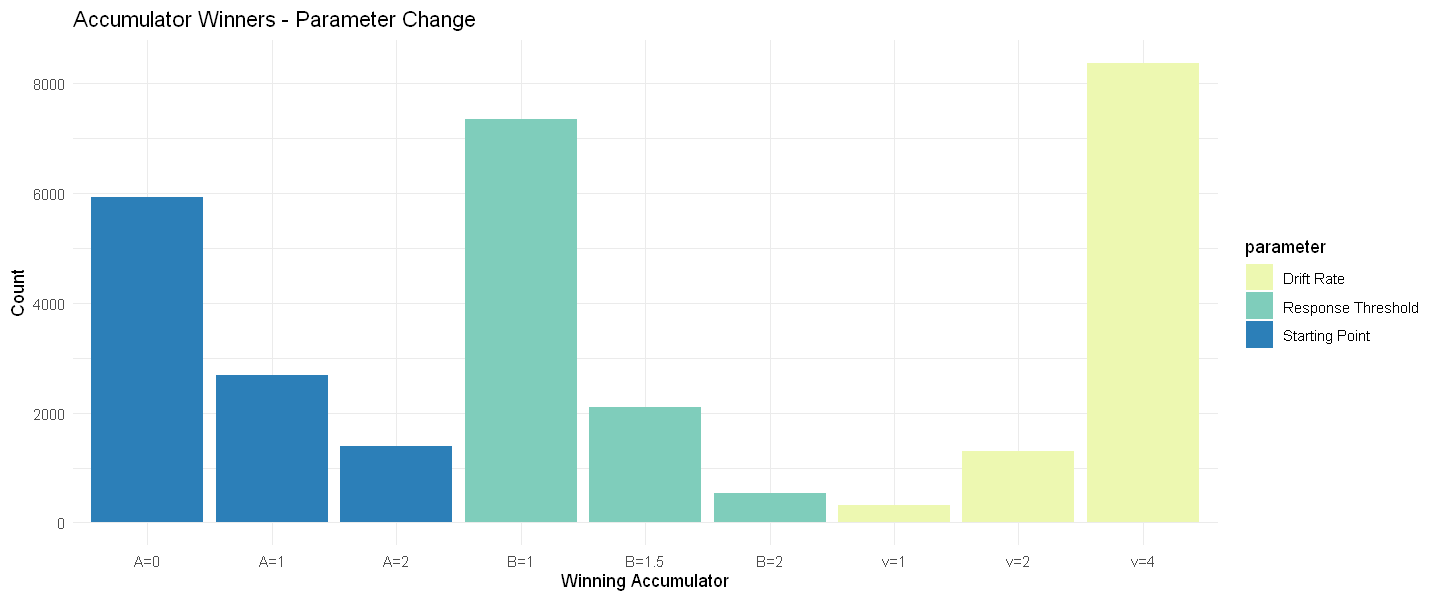

In [214]:
y_resp_plot = ggplot(y_long_resp, aes(x = factor(R), y = n, fill=parameter)) +
  geom_col() +
  labs(x = "Winning Accumulator", y = "Count", title = "Accumulator Winners - Parameter Change") +
  theme_minimal()+
  scale_fill_brewer(palette="YlGnBu") 
y_resp_plot

In [215]:
ggsave('y_v_rt_plot.jpg', plot = y_v_rt_plot, width = 10, height = 5)
ggsave('y_B_rt_plot.jpg', plot = y_B_rt_plot, width = 10, height = 5)
ggsave('y_A_rt_plot.jpg', plot = y_A_rt_plot, width = 10, height = 5)
ggsave('y_resp_plot.jpg', plot = y_resp_plot, width = 10, height = 5)

# MODEL FITTING


In [13]:
library(rtdists)
data(speed_acc)


In [14]:
wagenmaker_df = speed_acc %>% 
    filter(censor == FALSE) %>%
        mutate(frequency = recode(frequency, 'nw_low' = 'low', 'nw_very_low' = 'very_low', 'nw_high' = 'high')) %>%
        na.omit()


## OBJECTIVE FUNCTION

In [15]:
logger_mogger <- function(params, data) {
  # Extract parameters
  v_word <- c(high = params["v_word_high"], low = params["v_word_low"], very_low = params["v_word_very_low"])
  v_nonword <- c(high = params["v_nonword_high"],low = params["v_nonword_low"], very_low = params["v_nonword_very_low"])
  v_incorrect = params['v_incorrect']

  Bs <- params["Bs"]
  Ba <- params["Ba"]
  A <- params["A"]
  t0 <- params["t0"]

  ll <- 0
  
  for (i in 1:nrow(data)) {
    rt <- data$rt[i]
    if(rt <= t0){
      ll = ll + log(1e-3)
      next
    }
    stim_cat <- data$stim_cat[i]
    freq <- data$frequency[i]
    cond <- data$condition[i]
    resp_cat <- data$response[i]
    if(stim_cat == resp_cat){
      v = ifelse(stim_cat == "word", v_word[freq], v_nonword[freq])
    } else {
      v = v_incorrect
    }

    B = ifelse(cond == "speed", Bs, Ba) 
    t <- rt - t0

    dens <- dWald(t = t, v = v, B = B, A = A)

    if (is.na(dens) || dens <= 0 || is.nan(dens) || is.infinite(dens)) {
      ll <- ll + log(1e-3)  # Penalty
    } else {
      ll <- ll + log(dens)
    }
     
  }
  return(-ll)
}

## Simulated Data Validation

In [16]:
condition = rep('speed', times = 1000)

speed_cond = rWaldRace(n = 1000, v=c(4,2,1,3,1.5,0.75), B=1, A=0.5, t0=0.18) 
speed_cond = cbind(condition,speed_cond)  %>%
    rename(
        w_high = 'RT_acc1',
        w_low = 'RT_acc2',
        w_very_low = 'RT_acc3',
        nw_high = 'RT_acc4',
        nw_low = 'RT_acc5',
        nw_very_low = 'RT_acc6',
    )

condition = rep('acc', times = 1000)

acc_cond = rWaldRace(n = 1000, v=c(4,2,1,3,1.5,0.75), B=2, A=0.5, t0=0.18) 
acc_cond = cbind(condition,acc_cond)  %>%
    rename(
        w_high = 'RT_acc1',
        w_low = 'RT_acc2',
        w_very_low = 'RT_acc3',
        nw_high = 'RT_acc4',
        nw_low = 'RT_acc5',
        nw_very_low = 'RT_acc6',
    )

sim_4_recov_df = rbind(speed_cond, acc_cond)

sim_4_recov_df_long = sim_4_recov_df %>%
  pivot_longer(
    cols = starts_with("w_") | starts_with("nw_"),  # select only the relevant columns
    names_to = "stim_type_freq",
    values_to = "rt"
  ) %>%
  # Step 2: Separate the name into stim_cat and frequency
  mutate(
    stim_cat = if_else(str_starts(stim_type_freq, "w_"), "word", "nonword"),
    frequency = str_remove(stim_type_freq, "^(w_|nw_)"),
    response = stim_cat  # assuming response is the same as stim_cat
  ) %>%
  # Step 3: Select desired columns
  select(condition, stim_cat, frequency, rt, response) %>% 
    mutate (condition = factor(condition), stim_cat = factor(stim_cat), frequency = factor(frequency), response = factor(response))

In [17]:
test_params = c(
  v_word_high = 3.0,
  v_word_low = 1.5,
  v_word_very_low = 0.75, 
  v_nonword_high = 4,
  v_nonword_low = 2,
  v_nonword_very_low = 1,
  v_incorrect = 1.0,
  Bs = 1.0,
  Ba = 2.0,
  A = 0.5,
  t0 = 0.18
)

# sims_sanity_fit <- optim(
#   par = test_params,
#   fn = logger_mogger,
#   data = sim_4_recov_df_long, 
#   method = "L-BFGS-B",
#   lower = param_jail,
#   control = list(maxit = 10)
# )


In [18]:
# saveRDS(object = sims_sanity_fit, file = 'sims_sanity_fit.rds')
sims_sanity_fit = readRDS(file = 'sims_sanity_fit.rds')

In [217]:
sims_sanity_fit$par

v_word_high         v_word_low    v_word_very_low     v_nonword_high 
         4.0749550          2.2790907          1.0081660          3.2950949 
     v_nonword_low v_nonword_very_low        v_incorrect                 Bs 
         1.4742896          0.7430273          1.0000000          0.8885301 
                Ba                  A                 t0 
         2.0129473          0.7522999          0.1859293

## REAL DATA FITTING


In [19]:
init_params <- c(
  v_word_high = 4.0,
  v_word_low = 2.0,
  v_word_very_low = 1.0, 
  v_nonword_high = 3.0,
  v_nonword_low = 1.5,
  v_nonword_very_low = 0.75,
  v_incorrect = 1.0,
  Bs = 1.0,
  Ba = 2.0,
  A = 0.5,
  t0 = 0.18
)
param_jail = c(
    v_word_high = 0, v_word_low = 0, v_word_very_low = 0,
    v_nonword_high = 0, v_nonword_low = 0, v_nonword_very_low = 0,
    v_incorrect = 0, 
    Bs = 0, Ba = 0, A = 0, t0 = 0.18
)


In [20]:
# all_params <- list()
# all_other = list()
# # Loop through each participant
# for (i in unique(wagenmaker_df$id)) {
#   data = wagenmaker_df %>% filter(id == i)
  
#   fit <- optim(
#   par = init_params,
#   fn = logger_mogger,
#   data = data,  # Your preprocessed data for one participant
#   method = "L-BFGS-B",
#   lower = param_jail,
#   control = list(maxit = 10)
#   )
#   all_params[[i]] = c(fit$par)
#   all_other[[i]] = c(fit$convergence, fit$value, fit$counts)
# }


In [21]:
# saveRDS(object = all_params, file = 'all_recovered_params.rds')
# saveRDS(object = all_other, file = 'all_recovered_other.rds')

In [22]:
all_params = readRDS(file = 'all_recovered_params.rds')

In [23]:

# Combine into one data frame
param_table <- do.call(rbind, all_params)

# Reorder so participant_id is first column
# param_table <- param_table[, c(ncol(param_table), 1:(ncol(param_table)-1))]

In [24]:
param_table

,v_word_high,v_word_low,v_word_very_low,v_nonword_high,v_nonword_low,v_nonword_very_low,v_incorrect,Bs,Ba,A,t0
1,5.202767,4.345004,3.668015,4.404602,4.402690,4.3928879,2.760401,1.3164006,1.378152,0.26753575,0.2276522
2,4.080139,3.349044,2.907155,3.450565,3.416299,3.0926245,1.894111,0.9197738,1.478853,0.04515787,0.3295869
3,4.214557,3.221414,2.721497,3.414412,2.992679,2.8409964,1.762753,1.0130077,1.357193,0.51351060,0.1800000
4,5.371079,4.140032,3.447220,4.385876,3.882168,3.6627018,2.215791,0.9855729,1.182571,0.00000000,0.2632093
5,5.429003,4.795274,4.497824,4.654043,4.680795,4.7993521,2.187695,1.0047619,1.671739,0.21066550,0.2747303
6,5.207011,4.504030,3.931605,4.375656,4.356506,4.4212860,3.708271,1.0358760,1.704288,0.52866851,0.1800000
7,4.904228,3.936941,3.384633,4.092953,3.979756,3.9017120,4.349046,0.9650857,1.533210,0.54393205,0.1800000
8,3.999992,2.000019,1.000032,2.999991,1.500034,0.7500549,1.000063,0.9997203,1.999856,0.49987264,0.1911075
9,4.242777,3.506629,3.030028,3.677878,3.288199,3.5296434,2.297520,1.0294819,1.631121,0.19201079,0.2542930
10,5.296763,4.337067,3.913182,4.398814,4.220372,4.2940558,2.873926,0.9104033,1.437084,0.10273367,0.2480857


In [190]:
wagenmaker_df %>% group_by(id) %>%
summarise(mean_rt = sum(rt <= 0.25))

id,mean_rt
<fct>,<int>
1,0
2,1
3,3
4,0
5,0
6,7
7,10
8,21
9,0


# RECOVERY VALIDATION

In [47]:
# Define value ranges
t0_vals <- seq(0, 0.3, length.out = 50)
v_word_high_vals <- seq(1, 6, length.out = 50)
A_vals = seq(0, 2, length.out = 50)
Ba_vals = seq(0, 3, length.out = 50)
Bs_vals = seq(0, 3, length.out = 50)


## SUB1 SURFACES

In [54]:
sub1_params = all_params[[1]]
sub1_obs = wagenmaker_df %>% filter(id == 1)

In [55]:
grid_v_sub1 <- expand.grid(
  t0 = t0_vals,
  v_word_high = v_word_high_vals
)
grid_A_sub1 <- expand.grid(
  t0 = t0_vals,
  A = A_vals
)
grid_Bs_sub1 <- expand.grid(
  t0 = t0_vals,
  Bs = Bs_vals
)

In [149]:
# ll_surface_t0_v_sub1 <- apply(grid_v_sub1, 1, function(row) {
#   test_params <- sub1_params
#   test_params["t0"] <- row[1]
#   test_params["v_word_high"] <- row[2]
#   logger_mogger(test_params, sub1_obs)
# })
# saveRDS(object = ll_surface_t0_v_sub1, file='ll_surface_t0_v_sub1.rds')

grid_v_sub1$loglik = readRDS(file='ll_surface_t0_v_sub1.rds')

In [60]:
# ll_surface_t0_A_sub1 <- apply(grid_A_sub1, 1, function(row) {
#   test_params <- sub1_params
#   test_params["t0"] <- row[1]
#   test_params["A"] <- row[2]
#   logger_mogger(test_params, sub1_obs)
# })
# saveRDS(object = ll_surface_t0_A_sub1, file='ll_surface_t0_A_sub1.rds')
grid_A_sub1$loglik = readRDS(file='ll_surface_t0_A_sub1.rds')

In [64]:
# ll_surface_t0_Bs_sub1 <- apply(grid_Bs_sub1, 1, function(row) {
#   test_params <- sub1_params
#   test_params["t0"] <- row[1]
#   test_params["Bs"] <- row[2]
#   logger_mogger(test_params, sub1_obs)
# })
# saveRDS(object = ll_surface_t0_Bs_sub1, file='ll_surface_t0_Bs_sub1.rds')
grid_Bs_sub1$loglik = readRDS(file='ll_surface_t0_Bs_sub1.rds')


In [175]:
sub1_v_surf = ggplot(grid_v_sub1, aes(x = t0, y = v_word_high, fill = loglik)) +
  geom_tile() +
  scale_fill_viridis_c(option = "turbo") +
  labs(x = "t0", y = "v_word_high", fill = 'Negative \nLog-Likelihood') +
  theme_minimal()
ggsave(filename = "sub1_v_surf.jpg", plot = sub1_v_surf, width = 10, height = 5)

In [ ]:
sub1_A_surf = ggplot(grid_A_sub1, aes(x = t0, y = A, fill = loglik)) +
  geom_tile() +
  scale_fill_viridis_c(option = "turbo") +
  labs(x = "t0", y = "A", fill = 'Negative \nLog-Likelihood') +
  theme_minimal()
ggsave(filename = "sub1_A_surf.jpg", plot = sub1_A_surf, width = 10, height = 5)

In [176]:
sub1_Bs_surf = ggplot(grid_Bs_sub1, aes(x = t0, y = Bs, fill = loglik)) +
  geom_tile() +
  scale_fill_viridis_c(option = "turbo") +
  labs(x = "t0", y = "Bs", fill = 'Negative \nLog-Likelihood') +
  theme_minimal()
ggsave(filename = "sub1_Bs_surf.jpg", plot = sub1_Bs_surf, width = 10, height = 5)

## SUB8 SURFACES

In [65]:
sub8_params = all_params[[8]]
sub8_obs = wagenmaker_df %>% filter(id == 8)

In [66]:
grid_v_sub8 <- expand.grid(
  t0 = t0_vals,
  v_word_high = v_word_high_vals
)
grid_A_sub8 <- expand.grid(
  t0 = t0_vals,
  A = A_vals
)
grid_Bs_sub8 <- expand.grid(
  t0 = t0_vals,
  Bs = Bs_vals
)

In [ ]:
# ll_surface_t0_v_sub8 <- apply(grid_v_sub8, 1, function(row) {
#   test_params <- sub8_params
#   test_params["t0"] <- row[1]
#   test_params["v_word_high"] <- row[2]
#   logger_mogger(test_params, sub8_obs)
# })
# saveRDS(object = ll_surface_t0_v_sub8, file='ll_surface_t0_v_sub8.rds')

grid_v_sub8$loglik = readRDS(file='ll_surface_t0_v_sub8.rds')

In [ ]:
# ll_surface_t0_A_sub8 <- apply(grid_A_sub8, 1, function(row) {
#   test_params <- sub8_params
#   test_params["t0"] <- row[1]
#   test_params["A"] <- row[2]
#   logger_mogger(test_params, sub8_obs)
# })
# saveRDS(object = ll_surface_t0_A_sub8, file='ll_surface_t0_A_sub8.rds')
grid_A_sub8$loglik = readRDS(file='ll_surface_t0_A_sub8.rds')

In [ ]:
# ll_surface_t0_Bs_sub8 <- apply(grid_Bs_sub8, 1, function(row) {
#   test_params <- sub8_params
#   test_params["t0"] <- row[1]
#   test_params["Bs"] <- row[2]
#   logger_mogger(test_params, sub8_obs)
# })
# saveRDS(object = ll_surface_t0_Bs_sub8, file='ll_surface_t0_Bs_sub8.rds')
grid_Bs_sub8$loglik = readRDS(file='ll_surface_t0_Bs_sub8.rds')


In [177]:
sub8_v_surf = ggplot(grid_v_sub8, aes(x = t0, y = v_word_high, fill = loglik)) +
  geom_tile() +
  scale_fill_viridis_c(option = "turbo") +
  labs(x = "t0", y = "v_word_high", fill = 'Negative \nLog-Likelihood') +
  theme_minimal()
ggsave(filename = "sub8_v_surf.jpg", plot = sub8_v_surf, width = 10, height = 5)

In [178]:
sub8_A_surf = ggplot(grid_A_sub8, aes(x = t0, y = A, fill = loglik)) +
  geom_tile() +
  scale_fill_viridis_c(option = "turbo") +
  labs(x = "t0", y = "A", fill = 'Negative \nLog-Likelihood') +
  theme_minimal()
ggsave(filename = "sub8_A_surf.jpg", plot = sub8_A_surf, width = 10, height = 5)

In [179]:
sub8_Bs_surf = ggplot(grid_Bs_sub8, aes(x = t0, y = Bs, fill = loglik)) +
  geom_tile() +
  scale_fill_viridis_c(option = "turbo") +
  labs(x = "t0", y = "Bs", fill = 'Negative \nLog-Likelihood') +
  theme_minimal()
ggsave(filename = "sub8_Bs_surf.jpg", plot = sub8_Bs_surf, width = 10, height = 5)

## SUBJECT DATA AND RECOVERED PARAMETER SIMULATION

In [69]:
sub1_v_words = sub1_params[1:3]
sub1_v_nonwords = sub1_params[4:6]
sub1_v_incorrect = sub1_params[7]
sub1_Bs = sub1_params[[8]]
sub1_Ba = sub1_params[[9]]
sub1_A = sub1_params[[10]]
sub1_t0 = sub1_params[[11]]


In [ ]:
sub1_sims = list()
for(i in 1:nrow(sub1_obs)){
    condition = sub1_obs$condition[i]
    stim_cat = sub1_obs$stim_cat[i]
    frequency = sub1_obs$frequency[i]
    if(stim_cat == 'word'){
        v = sub1_v_words[paste('v_word_', frequency, sep="")][[1]]
    } else {
        v = sub1_v_nonwords[paste('v_nonword_', frequency, sep="")][[1]]
    }
    B = ifelse(condition == 'speed', yes = sub1_Bs, no = sub1_Ba)
    sim = rWaldRace(n = 1, v = c(v, sub1_v_incorrect), B = B, A = sub1_A, t0 = sub1_t0)
    opt = c('word', 'nonword')
    response <- if (sim$R == 1) stim_cat else setdiff(opt, stim_cat)
    rt = sim$RT
    sub1_sims[[i]] <- data.frame(
    condition = condition,
    stim_cat = stim_cat,
    frequency = frequency,
    response = response,
    rt = rt
    )
}


v_incorrect 
   2.760401 


In [124]:
simmers = do.call(rbind, sub1_sims) 
simmers$source = 'simulated'
ss_obs = wagenmaker_df %>% filter(id == 1) %>% select(condition, stim_cat, frequency, response, rt)
ss_obs$source = 'observed'

In [134]:
bombination <- rbind(simmers, ss_obs) %>%
  mutate(
    stim_cat = as.character(stim_cat),
    response = as.character(response),
    correct = stim_cat == response
  )

bombination

condition,stim_cat,frequency,response,rt,source,correct
<fct>,<chr>,<fct>,<chr>,<dbl>,<chr>,<lgl>
speed,nonword,low,nonword,0.5723227,simulated,TRUE
speed,word,very_low,nonword,0.4500864,simulated,FALSE
speed,nonword,very_low,word,0.4038676,simulated,FALSE
speed,word,very_low,word,0.5220874,simulated,TRUE
speed,word,low,word,0.5536272,simulated,TRUE
speed,nonword,high,nonword,0.3453982,simulated,TRUE
speed,word,high,nonword,0.4603922,simulated,FALSE
speed,nonword,low,nonword,0.7252640,simulated,TRUE
speed,nonword,low,word,0.4590596,simulated,FALSE


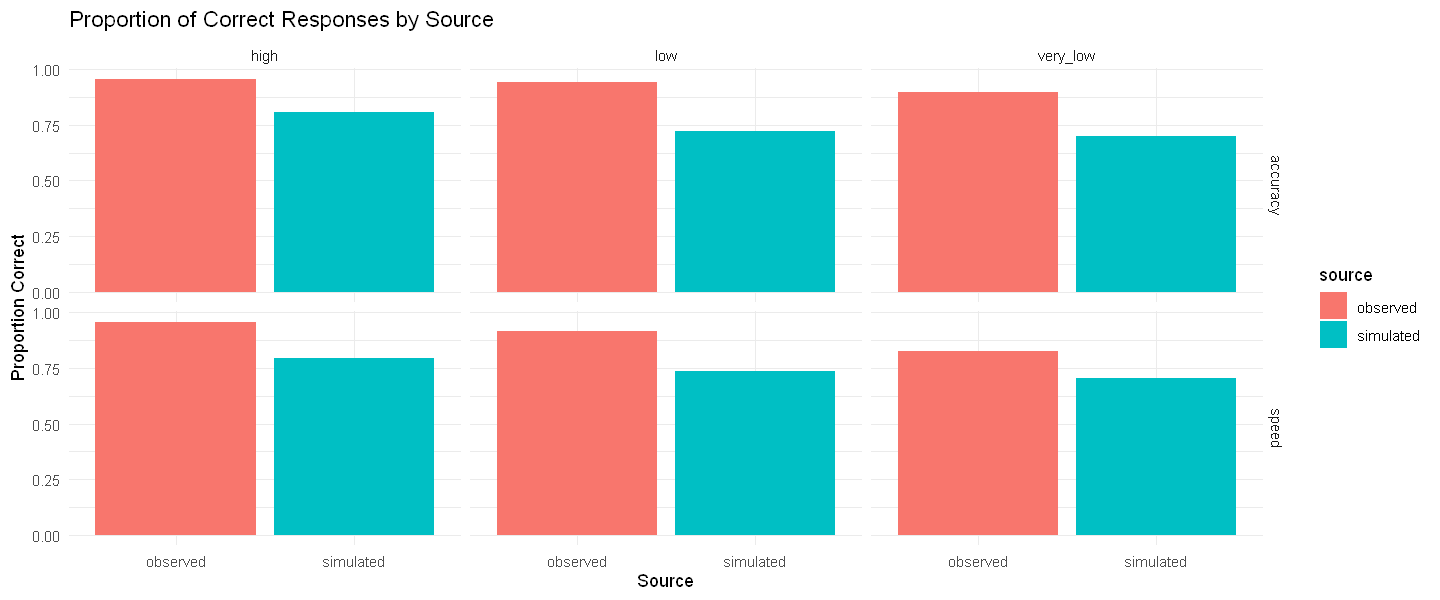

In [142]:
bombination_sum <- bombination %>%
  group_by(source, condition, frequency) %>%
  summarise(correct = mean(correct), .groups = "drop")

# Bar plot
ggplot(bombination_sum, aes(x = source, y = correct, fill = source)) +
  geom_bar(stat = "identity", position = "dodge") +
  facet_grid(condition ~ frequency) +
  labs(
    title = "Proportion of Correct Responses by Source",
    x = "Source",
    y = "Proportion Correct"
  ) +
  theme_minimal()

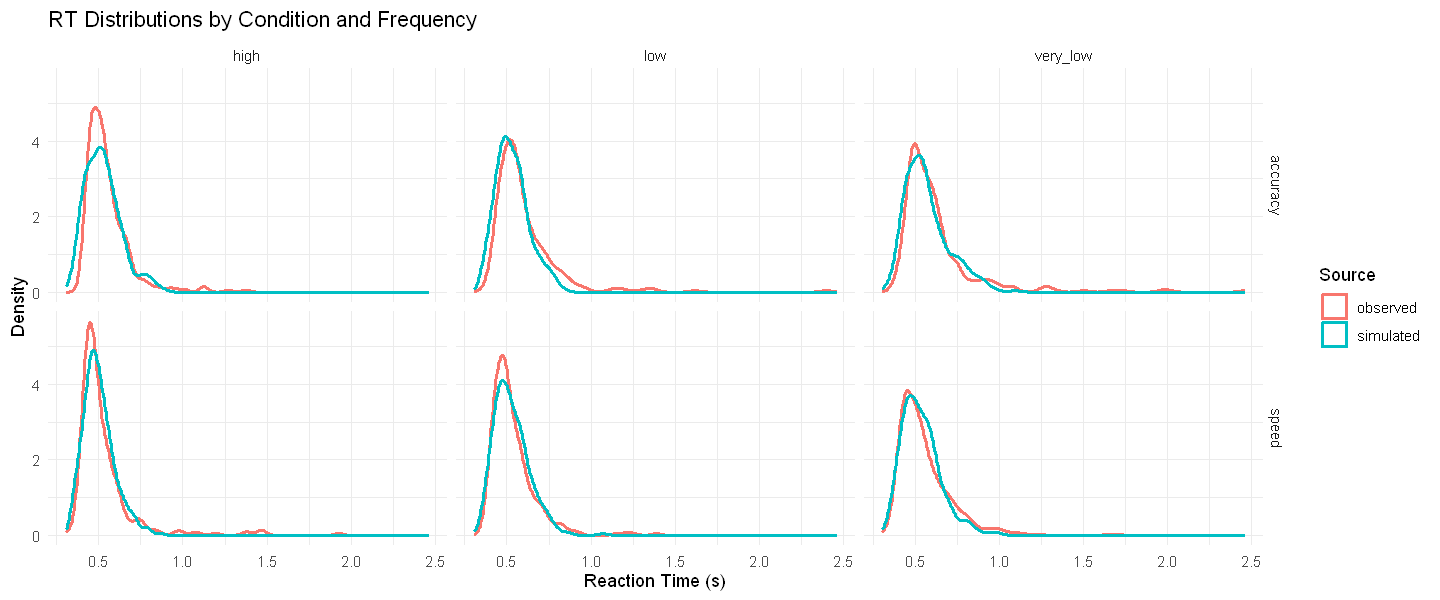

In [146]:
ggplot(data = bombination, aes(x = rt, color = source)) +
  geom_density(size = 1) +
  facet_grid(condition ~ frequency) +
  labs(
    title = "RT Distributions by Condition and Frequency",
    x = "Reaction Time (s)",
    y = "Density",
    color = "Source"
  ) +
  theme_minimal()